In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Import Data

In [82]:
data = pd.read_csv('../raw_data/fer2013.csv')

In [83]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Custom functions

In [14]:
# clean dataset of blank pictures
def clean_dataset(dataframe):
    # Create std deviation of pixels (colour in image) column
    values = [np.array(pixels.split(),np.int16).std() for pixels in dataframe.pixels]
    values = pd.Series(values).to_frame('Std')
    dataframe['std_dev'] = values
    # filter out images with 0 variance
    dataframe = dataframe.loc[dataframe['std_dev'] > 0]
    # delete column
    dataframe = dataframe.drop(['std_dev'], axis=1)
    return dataframe

In [13]:
# convert dataframe row ('pixels' column) to image
def row2image(row):
    emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    return img.astype(np.uint16), emotion

In [15]:
from numpy import expand_dims
import copy

# expand each array to 4D (1, X, X, 1) for flow
def expandto4D(x):
    # if array of arrays
    Xpanded = copy.deepcopy(x)
    if x.ndim == 1:
        for i in range(0,len(x)):
            Xpanded[i] = np.expand_dims(Xpanded[i], 0)
            Xpanded[i] = np.expand_dims(Xpanded[i], 3)
    # if single array
    elif x.ndim == 2:
        Xpanded = np.expand_dims(Xpanded, 0)
        Xpanded = np.expand_dims(Xpanded, 3)
    return Xpanded

# squeeze back to 2D (X, X) for dataframe
def squeezeto2D(x):
    Xpanded = copy.deepcopy(x)
    if Xpanded.ndim == 4:
        # remove first dimension of 4D array
        squeezed = np.squeeze(Xpanded, axis=0)
        # remove last dimension of 3D array
        squeezed = np.squeeze(squeezed, axis=2)
    return squeezed

In [16]:
# convert string to array
def string2array(x):
    pixels = copy.deepcopy(x)
    if isinstance(pixels,np.ndarray):
        for i in range(0,len(pixels)):
            pixels[i] = np.fromstring(pixels[i], dtype=int, sep=' ').reshape((48,48))
    elif isinstance(pixels,str):
        pixels = np.fromstring(pixels, dtype=int, sep=' ').reshape((48,48))
    return pixels

# convert array to string
def array2string(x):
    converted = copy.deepcopy(x)
    converted = (converted).flatten().tolist()
    converted = " ".join(str(round(x)) for x in converted)
    converted = converted.replace("\n","")
    return converted

In [17]:
# 2Darray-label combination to labelled image
def labelledarray2image4D(X,y):
    emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    expandto4D(X)
    pixels, emotion = X, y
    img = X.reshape(48,48)
    return img.astype(np.uint16), emotion_map[emotion]

# 2D to 4D array
def array2image4D(img):
    img = img.reshape(0,48,48,0)
    return img.astype(np.uint16)

## Clean dataset

In [84]:
data = clean_dataset(data)

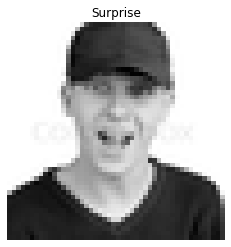

In [20]:
# image check
img, emotion = row2image(data.iloc[55])
plt.title(emotion, size=12)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off');

In [19]:
# new column converting pixels string to reshaped array
# data['pixels_array'] = data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((48,48)))

## Label emotions

In [72]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4945
1,Fear,5121
2,Sad,6076
3,Neutral,6197
4,Happy,8988
5,Surprise,4001
6,Disgust,547


## Data checks

In [22]:
## shape of the dataset

data.shape

(35875, 3)

In [23]:
## checking for null values

data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [28]:
## check image sizes

data['image_sizes'] = data['pixels'].apply(lambda x: len(x.split()))
data.head()

,emotion,pixels,Usage,image_sizes
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,2304
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,2304
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,2304
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,2304
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,2304


In [29]:
data = data.drop(['image_sizes'], axis=1)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35870,2,6 8 4 5 30 48 61 70 76 79 98 117 130 137 143 1...,PrivateTest
35871,6,112 102 98 89 98 133 164 185 180 179 185 169 1...,PrivateTest
35872,5,131 159 90 59 10 0 1 1 1 0 1 1 0 0 2 2 5 7 9 1...,PrivateTest
35873,4,54 57 77 122 121 76 73 80 58 22 26 27 35 41 66...,PrivateTest


In [30]:
class_dis = emotion_counts.number.max()

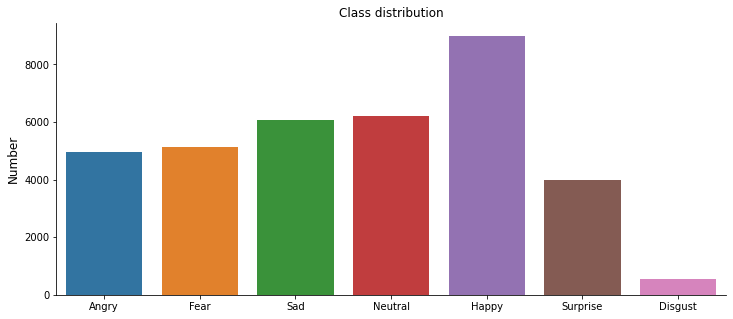

In [31]:
plt.figure(figsize=(12,5))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('', fontsize=12)
sns.despine()
plt.show()

In [32]:
from sklearn.metrics import classification_report

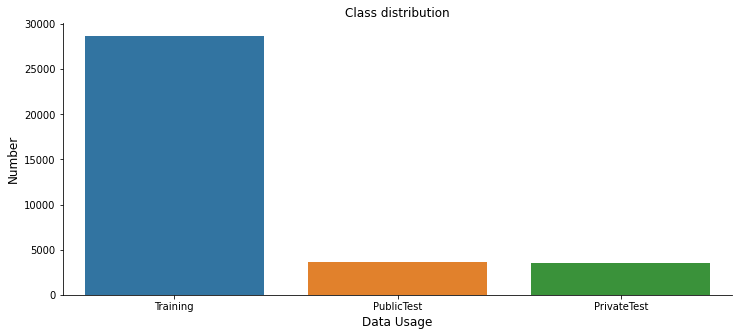

In [33]:
usage_counts = data['Usage'].value_counts(sort=False).reset_index()
usage_counts.columns = ['usage', 'number']

plt.figure(figsize=(12,5))
sns.barplot(x=usage_counts.usage, y=usage_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Data Usage', fontsize=12)
sns.despine()
plt.show()

## Visualise dataset

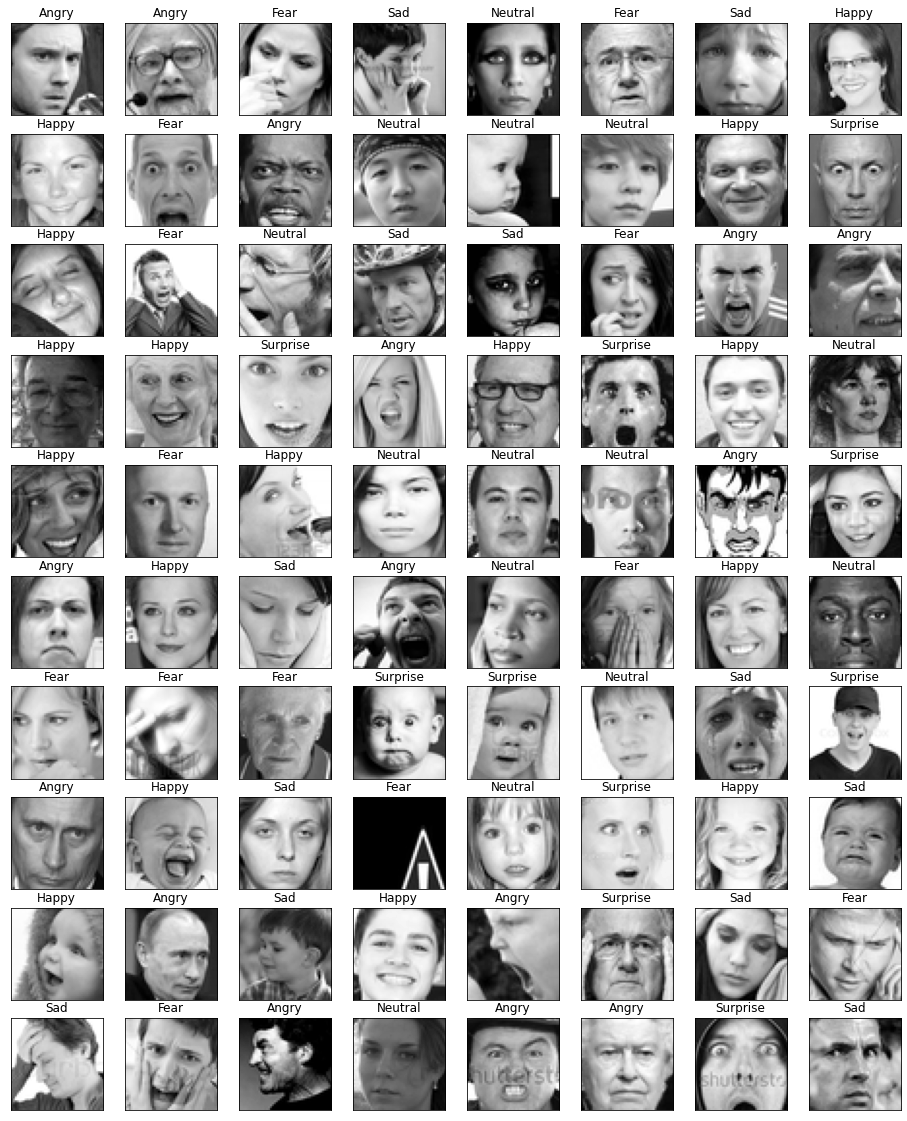

In [85]:
fig = plt.figure(figsize=(16,20))

train_data = data.loc[data['Usage'] == "Training"]
for i in range(80):
    img = row2image(train_data.iloc[i])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

In [86]:
# delete identified blank image
data = data.drop([59])

# Data augmentation

## Load original images

In [87]:
## Create variables for training, validation and test data
train_set = data.loc[data['Usage'] == 'Training']
val_set = data.loc[data['Usage'] == 'PublicTest']
test_set = data.loc[data['Usage'] == 'PrivateTest']

In [88]:
# load image dataset
X, y = train_set['pixels'].to_numpy(), train_set['emotion'].to_numpy()

In [89]:
# filter dataset for augmentation further if applicable
# X_aug = X
# y_aug = y

# if full training set is to be used
X_aug = X
y_aug = y

In [90]:
# expand each image array to 4D for flow
X_aug4D = expandto4D(string2array(X_aug))

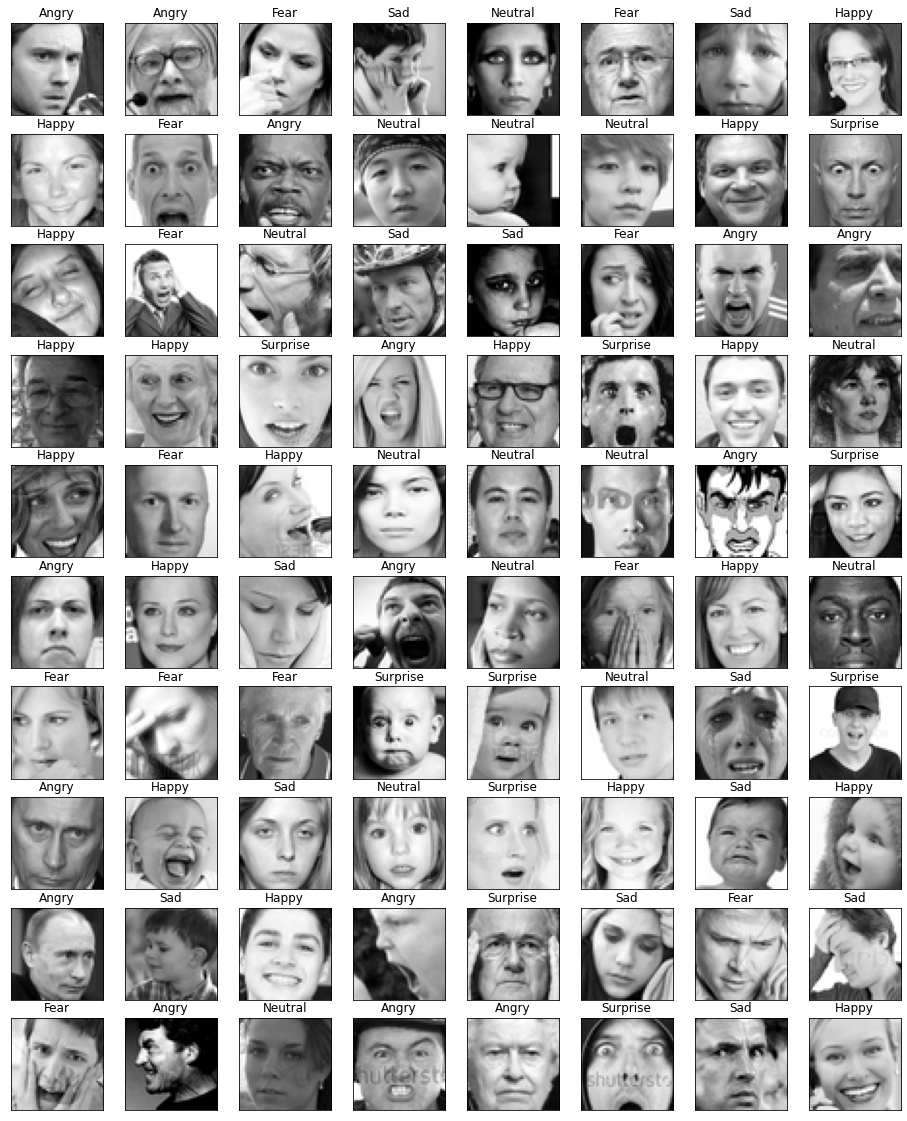

In [46]:
fig = plt.figure(figsize=(16,20))

for i in range(0,80):
    img = labelledarray2image4D(X_aug4D[i], y_aug[i])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

## Define image data generation specs

In [54]:
# create data generator
datagen = ImageDataGenerator(
    rotation_range=45, width_shift_range=5,
    height_shift_range=5, shear_range=0.25, zoom_range=0.5,
    channel_shift_range=3, horizontal_flip=True,
    brightness_range=(0.2, 0.8)
)

In [55]:
# Define target amount of images per category
target_size = {}
target_size[0] = 8000
target_size[1] = 2180
target_size[2] = 8000
target_size[3] = 8000
target_size[4] = 8000
target_size[5] = 8000
target_size[6] = 8000

## Run ImageDataGenerator

In [58]:
y[0].reshape(1,1)

array([[0]])

In [99]:
import warnings; warnings.simplefilter('ignore')

In [ ]:
AugmentedDataset = []
for emotion in range(0,7):
    print(f'Data shape:',data.shape[0])
    filtered = data.loc[data['emotion'] == emotion]
    filtered = filtered.loc[filtered['Usage'] == 'Training']
    X, y = filtered['pixels'].to_numpy(), filtered['emotion'].to_numpy()
    X_aug4D = expandto4D(string2array(X))
    print(f'New emotion loop: {emotion}: {len(y)}')
    for sample in range(0,len(y)):
        for image, label in datagen.flow(X_aug4D[sample],y=y[sample].reshape(1,1)):
            AugmentedDataset.append((image, label))
            new_row = {'emotion':y[sample], 'pixels':array2string(image), 'Usage':"DataAug"}
            data = data.append(new_row, ignore_index=True)
            filtered = filtered.append(new_row, ignore_index=True)
            if filtered.shape[0] >= target_size[emotion]:
                print(f'emotion {emotion}: generated {filtered.shape[0]}, target was {target_size[emotion]}')
                print(f'Data shape:',data.shape[0])
                print(f'New data = {data.shape[0] - filtered.shape[0]}/n',)
                break
data.to_csv('AugmentedImages/AugmentedDataset.csv', index=False)
print("That's all folks!")

## Visualise augmented dataset

In [111]:
augmentation = pd.read_csv('AugmentedImages/NewAugmentedData.csv')
augmentation = augmentation[(augmentation['Usage'] == 'DataAug') | (augmentation['Usage'] == 'Training')]
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
augmentation_counts = augmentation['emotion'].value_counts(sort=False).reset_index()
augmentation_counts.columns = ['emotion', 'generated']
augmentation_counts['emotion'] = augmentation_counts['emotion'].map(emotion_map)
augmentation_counts

,emotion,generated
0,Angry,8000
1,Fear,8000
2,Sad,4830
3,Neutral,8000
4,Happy,8000
5,Surprise,8000
6,Disgust,8000


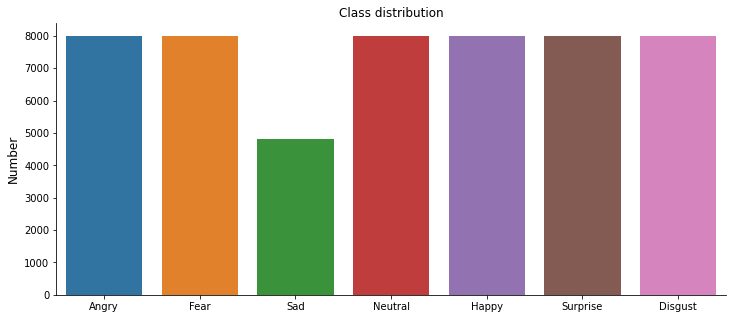

In [163]:
plt.figure(figsize=(12,5))
sns.barplot(x=augmentation_counts.emotion, y=augmentation_counts.generated)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('', fontsize=12)
sns.despine()
plt.show()

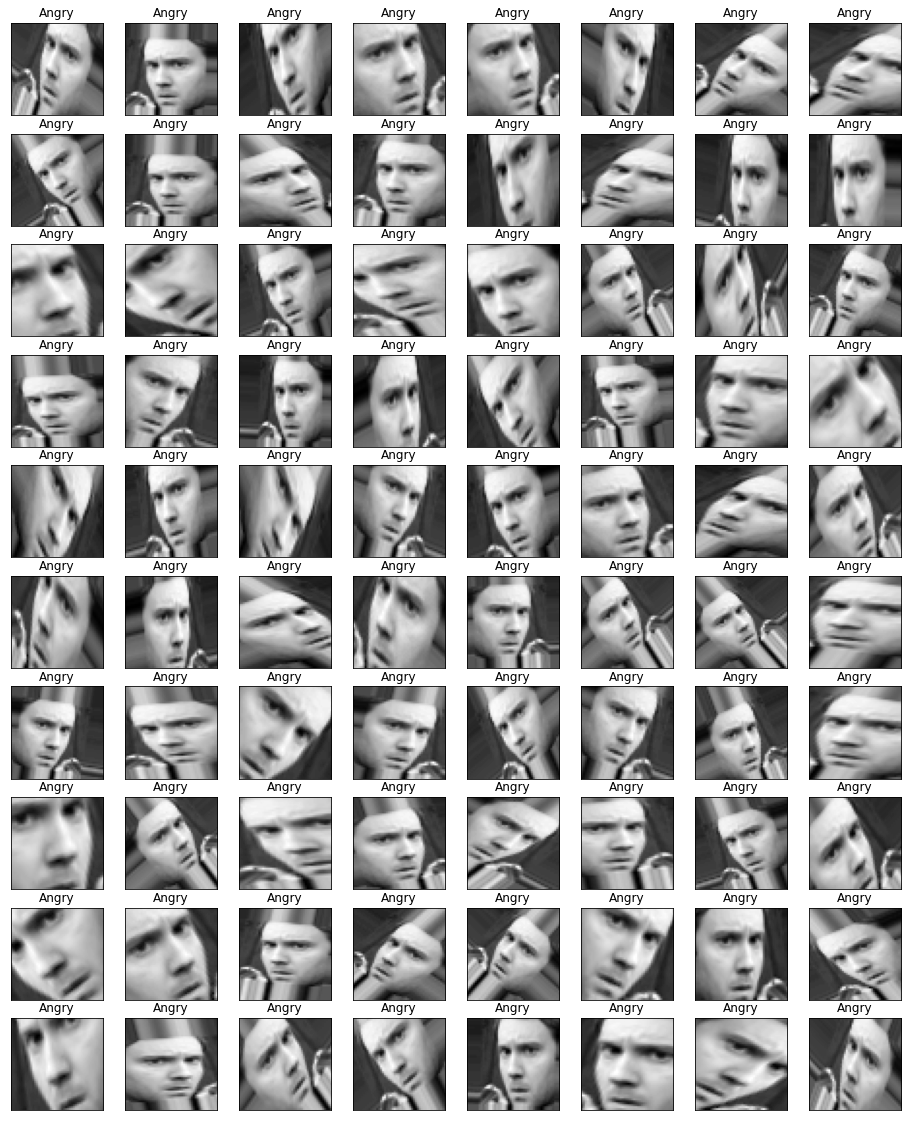

In [144]:
# visualize generated images
fig = plt.figure(figsize=(16,20))

for i in range(0,80):
    img, label = row2image(augmentation.loc[augmentation['Usage'] == 'DataAug'].iloc[i])
    plt.subplot(10, 8, i + 1)
    plt.title(label, size=12)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());

## Image to compatible array

In [44]:
from skimage.transform import resize

# load img in greyscale
img = load_img('SamplePhoto/SamplePhoto.png', color_mode='grayscale')
# convert loaded image to 4D array
img_array = img_to_array(img)  # creating a Numpy array with shape (X, X, 3)
img_resized = resize(img_array, (48, 48)) #resize to match dataset
img_array = img_resized.reshape((1,) + img_resized.shape)  # converting to a Numpy array with shape (X, X, 3, 1)

In [45]:
img_array.shape

(1, 48, 48, 1)

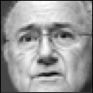

In [46]:
img

In [47]:
resized_array = squeezeto2D(img_array)

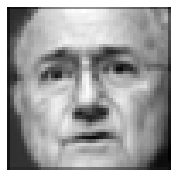

In [48]:
# show image
plt.figure(figsize=(3,3))
plt.imshow(resized_array, cmap=plt.cm.gray, aspect='equal')
plt.axis('off');